In [12]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Documents/GitHub/MA999-slides`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /Users/paoloturrini/Documents/GitHub/MA999-slides/Manifest.toml:0
Precompiling project...
  ✓ SuiteSparse_jll
  ✓ KLU
  ✓ Sundials_jll
  ✓ LinearSolve
  ✓ Sundials
  ✓ OrdinaryDiffEq
  ✓ DiffEqCallbacks
  ✓ DelayDiffEq
  ✓ StochasticDiffEq
  ✓ SteadyStateDiffEq
  ✓ DifferentialEquations
  11 dependencies successfully precompiled in 128 seconds (297 already precompiled)


In [13]:
using Agents
using Plots
using DataFrames

# MA999 - Agent based modelling 1 - introduction

## MathSys CDT 2022

### Lecturer: Paolo Turrini (with massive acknowledgments to Colm Connaughton) 

## Summary

* What is agent-based modelling?
* Example 1: one-dimensional cellular automata
* Agents.jl - Agent-based modelling in Julia
* Example 2: Traffic flow and congestion games
* Mathematical analysis of congestion games: Braess' paradox and the price of anarchy
* Example 3: Gaia hypothesis: planetary homeostasis in the Daisyworld model
* Mathematical analysis of the mean field Daisyworld model

## What is agent based modelling?
* An ABM is a model built from multiple autonomous agents that react to their environment (including the other agents) using a predefined set of rules.
* The environment can, in turn, be altered by the actions of the agents.
### Advantages
* Massive flexibility - many of the assumptions of "mathematical" models can be relaxed.
* Easy to simulate and visualise.
* Can handle heterogeneity in a natural way - not all agents need to be identical.
* Often the only option for studying complex adaptive systems.

### Disadvantages
* Potentially large number of parameters and rather under-developed theory for model selection.
* Temptation to favour model "fidelity" over parsimony can lead to inappropriate predictive use.
* Can become computationally expensive.
* Complex ABMs are difficult to understand.

##  Example 1: one-dimensional cellular automata

* "Agents" are nodes on a one-dimensional grid: $G = \{v1, v2, \ldots v_N\}$.
* Each agent has a single "state" attribute,$x_i$, taking values 0 or 1.
* Time proceeds in discrete steps.
* At each step, agents update states based on neighbouring states.
* Such a model is specified by:
    * initial state, $X(0) = \{x_1(0), x_2(0), \ldots x_N(0)\}$.
    * an update rule that maps the current states of an agent and its neighbours to the new state:
    $$S : (x_{i-1},\, x_i,\, x_{i+1}) \to x_i$$
    

##  Example 1: one-dimensional cellular automata

$$S : (x_{i-1},\, x_i,\, x_{i+1}) \to x_i$$

* How many such rules are there?
    * a rule must specify an output bit for $2^3 = 8$ possible input configurations of 3 bits.
    * hence there are $2^8 = 256$ rules. 

## Naming one-dimensional CA : the Wolfram code

Stephen Wolfram devised what is now the standard rule for naming 1D CA. Each rule is assigned a number between 0 and 255.

* Write each of the possible configurations in order and its corresponding output value as follows:

|Input | 111 | 110 | 101 | 100 | 011 | 010 | 001| 000 |
| - | - | - | - | - | - | - | - | - |
|Output | 0 | 1 | 1 | 0 | 1 | 1 | 1 | 0 |

* Interpret the output row as a binary integer to give the rule number.

## Naming one-dimensional CA : the Wolfram code

|Input | 111 | 110 | 101 | 100 | 011 | 010 | 001| 000 |
| - | - | - | - | - | - | - | - | - |
|Output | 0 | 1 | 1 | 0 | 1 | 1 | 1 | 0 |

The above rule is $0 \times 128 + 1\times 64 + 1\times 32 + 0\times 16 + 1\times 8 +1\times 4 + 1 \times 2 + 0\times 1 = 110$. 

Let's simulate rule 110 in Julia to see what the evolution looks like.

## Simulation of 1D CA in Julia

The Julia package Agents.jl provides a framework for simulating ABMs. I have written a custom module called ```CA1D``` that uses Agents.jl to simulate 1D CA. Let's first play around with it. Then we will look at how the code works. First load the module:

In [14]:
include("code/CA1D.jl")

Main.CA1D

### Step 1 : define the update rule for an agent

Agents.jl uses dictionaries a lot so learn how they work: 

In [15]:
rule110 = Dict("111"=>0, "110"=>1, "101"=>1, "100"=>0, "011"=>1,
            "010"=>1, "001"=>1, "000"=>0)

rule22 = Dict("111"=>0, "110"=>0, "101"=>0, "100"=>1, "011"=>0,
            "010"=>1, "001"=>1, "000"=>0)

Dict{String, Int64} with 8 entries:
  "000" => 0
  "111" => 0
  "001" => 1
  "011" => 0
  "101" => 0
  "110" => 0
  "010" => 1
  "100" => 1

### Step 2 : build and initialise the model

Building involves several sub-steps:

* Define the spatial grid - in this case just a 1D grid.
* Pass any additional model parameters to the model - none here
* Add the agents to the model - trivial here since the agents and the grid are the same.
* Initialise the parameters of the model - here we set the middle agent to be active

In [16]:
n = 101
model = CA1D.initialise(;rules = rule110, gridsize = n, initial_condition="singleton")

AgentBasedModel with 101 agents of type CA1DAgent
 space: GridSpace with size (101,), metric=euclidean, periodic=true
 scheduler: fastest
 properties: Dict(:rules => Dict("000" => 0, "111" => 0, "001" => 1, "011" => 1, "101" => 1, "110" => 1, "010" => 1, "100" => 0))

### Step 3 : run the model and gather some data

* We just need to specify the number of steps and let Agents.jl take care of the rest.
* We do a number of runs half the size of the grid.
* Data is returned from the simulation in a dataframe object : https://juliadata.github.io/DataFrames.jl/stable/

In [17]:
steps = round(Int64, n)
p, data = CA1D.run(;rules = rule22, gridsize = n, initial_condition="singleton", nsteps=steps, update="synchronous")

(Plot{Plots.GRBackend() n=1}, [0 0 … 0 1; 1 0 … 1 1; … ; 1 1 … 1 0; 0 0 … 0 0])

### Step 4 : analyse the data

* Here we just visualise the output by plotting the array of zeros and ones at consecutive steps.

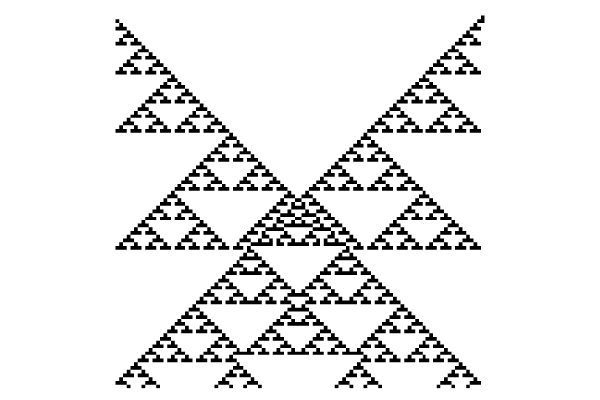

In [18]:
p

We conclude that even very simple ABMs can have very complex behaviour.

Let's try it with a random initial condition or a different rule...

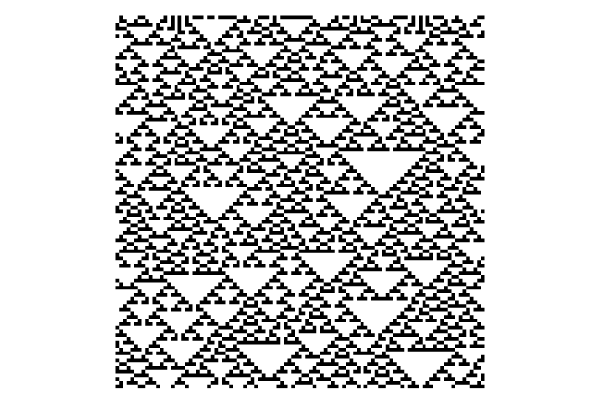

In [19]:
p, data = CA1D.run(;rules = rule22, gridsize = n, initial_condition="random", nsteps=steps, update="synchronous")
p

## A closer look at Agents.jl
The CA is too simple to illustrate all the features that are present in general ABMs. In particular, the lack of distinction between the space  grid and the agents is not generic. 

Agents.jl provides framework for constructing, running and analysing a broad class of ABMs. It *is* faster than writing yourself from scratch.


### Features of a general ABM

* an **agent** object with its own features
* a **model** object with its own features
* a **space** in which the agents live (in Agents.jl the space is a feature of the model, "no space" is possible)
* an **agent update** function
* a **model update** function
* a **scheduler**: a protocol for deciding the order in which the agents in the model run their update functions

### Overview of the structure of the Agents.jl framework
From https://juliadynamics.github.io/Agents.jl/dev/tutorial/ 

<img src="files/images/AgentsJL_overview.png" alt="Agents" style="width: 400px;"/>



### Data types in the Agents.jl framework

![Overview of Agents.jl](files/images/AgentsJL_model_object_structure.png "Agents.jl")

from https://juliadynamics.github.io/Agents.jl/dev/tutorial/ 

## Example 1: the 1D CA "under the hood"

Let's look at how the code for the 1D CA above fits into this framework.

There are lots of other examples in the Agents.jl documentation.

### Step 1 : defining the agent, space and model objects

Agents are always defined as mutable subtypes of ```AbstractAgent```. Depending on the space, the agent must have certain properties. For example, when the space is a ```GridSpace```, the agent must have a ```pos``` field of the appropriate dimension:

In [20]:
mutable struct CA1DAgent <: AbstractAgent
    id::Int # The identifier number of the agent
    pos::Dims{1} # The x location of the agent on a 1D grid
    state::Int # The state of the agent - 0 or 1
end

### Step 1 : defining the agent, space and model objects

Agents.jl pre-defines several types of agent matching with different types of space and provides a macro to customise these. In our case, we want to customise a ```GridAgent{1}```:

In [21]:
@agent CA1DAgent GridAgent{1} begin
    state::Int
end

### Step 1 : defining the agent, space and model objects

The space in this case is a 1D grid

In [22]:
gridsize = 101
space = GridSpace((gridsize,), metric=:euclidean, periodic = true)

GridSpace with size (101,), metric=euclidean, periodic=true

### Step 1 : defining the agent, space and model objects

The model incorporates the agent, the space and any additional properties needed to specify the model.

In our case, the only additional properties the model needs is the rules that we have defined above

In [23]:
space = GridSpace((gridsize,), metric=:euclidean, periodic = true)
properties = Dict(:rules => rule110)
model = ABM(CA1DAgent, space; properties)

AgentBasedModel with 0 agents of type CA1DAgent
 space: GridSpace with size (101,), metric=euclidean, periodic=true
 scheduler: fastest
 properties: Dict(:rules => Dict("000" => 0, "111" => 0, "001" => 1, "011" => 1, "101" => 1, "110" => 1, "010" => 1, "100" => 0))

### Step 1 : defining the agent, space and model objects

After creating the model, we now need to add the agents to it. In this case, there is an agent at each point on the grid. Let's start off with all of them set to state 0 except for the last one:


In [24]:
for idx in 1:gridsize
    add_agent_pos!(CA1DAgent(idx, (idx,), 0), model)
end
model.agents[gridsize].state = 1

1

### Aside: Using a function to initialise an ABM

It is a good idea to package all of this together into a single function to initialise an ABM. Here we take advantage of Julia's ability to define default function arguments:

In [25]:
function initialise(;rules = rule110, gridsize = 101)
    space = GridSpace((gridsize,), metric=:euclidean, periodic = true)
    properties = Dict(:rules => rules)
    model = ABM(CA1DAgent, space; properties)
    
    for idx in 1:gridsize
        add_agent_pos!(CA1DAgent(idx, (idx,), 0), model)
    end
    model.agents[gridsize].state = 1  
    return model
end

initialise (generic function with 1 method)

### Step 2 : defining the agent update function

This is where all of the action takes place:

In [26]:
function agent_step!(agent, model)
    neighbourhood = nearby_ids(agent.pos, model)
    str = ""
    for idx in neighbourhood
        str=str*string(model.agents[idx].state)
    end
    agent.state = model.rules[str]
end

agent_step! (generic function with 1 method)

### Step 3 : running the model and extracting data

In [27]:
nsteps = 50
adata = [:pos, :state]
data, _ = run!(model, agent_step!, nsteps; adata);

In [28]:
data[1:5,:]

,step,id,pos,state
,Int64,Int64,Tuple…,Int64
1,0,1,"(1,)",0
2,0,2,"(2,)",0
3,0,3,"(3,)",0
4,0,4,"(4,)",0
5,0,5,"(5,)",0


Agents.jl uses a DataFrame to return the data from run. You need to learn how to manipulate them

In [29]:
# Process the data into a simple array for plotting
    A = zeros(Int64, (nsteps+1, nagents(model)))
    for i in 0:nsteps
        snapshot = data[data[!,:step] .== i, :]
        for j in Iterators.flatten(snapshot.pos)
            A[i+1,j] = snapshot.state[j]
        end
    end

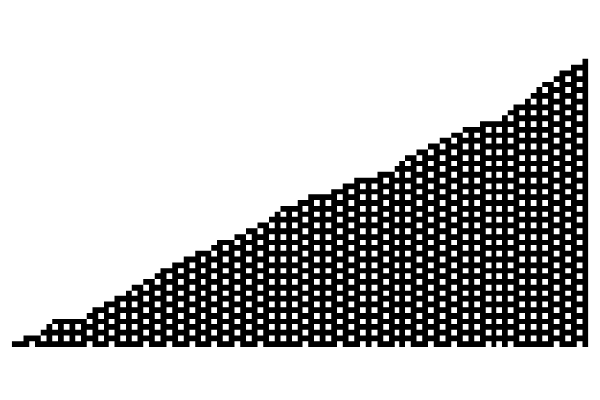

In [30]:
 # Reverse the image to make it plot nicer
    B = map( x -> x == 0 ? 1 : 0, A)
    p = plot(Gray.(B), aspect_ratio = :equal, ylim=(0,nsteps+1), axis=nothing, xaxis=false, yaxis=false)

### Synchronous vs asynchronous update - defining a model update function

What happened? We need our model to update synchronously. This is most easily done by defining a model update function that updates the agents:

In [31]:
function model_step!(model)
    new_states =  fill(0, nagents(model))
    for agent in allagents(model)
        neighbourhood = nearby_ids(agent.pos, model)
        str = ""
        for idx in neighbourhood
            str=str*string(model.agents[idx].state)
        end
        new_states[agent.id] = model.rules[str]
    end
    
    # Now that we have worked out all the new states, overwrite the old states
    for k in keys(model.agents)
        model.agents[k].state = new_states[k]
    end
end

model_step! (generic function with 1 method)

### Synchronous vs asynchronous update - defining a model update function

Now run again with a different form of the run!() function. Agents.jl provides a ```dummystep``` function for ABMs that don't require an ```agent_step!()``` function:

In [32]:
model = initialise(;rules = rule110, gridsize = 101)
nsteps = 50
adata = [:pos, :state]
data, _ = run!(model, dummystep, model_step!, nsteps; adata);

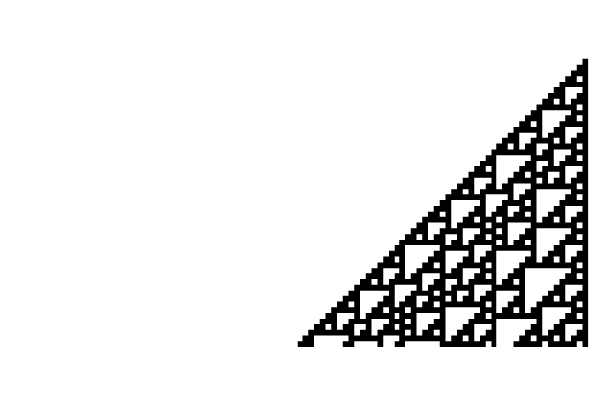

In [33]:
# Process the data into a simple array for plotting
    A = zeros(Int64, (nsteps+1, nagents(model)))
    for i in 0:nsteps
        snapshot = data[data[!,:step] .== i, :]
        for j in Iterators.flatten(snapshot.pos)
            A[i+1,j] = snapshot.state[j]
        end
    end

 # Reverse the image to make it plot nicer
    B = map( x -> x == 0 ? 1 : 0, A)
    p = plot(Gray.(B), aspect_ratio = :equal, ylim=(0,nsteps+1), axis=nothing, xaxis=false, yaxis=false)

### Aside: Running an ABM inside a function

As with initialisation, it can be helpful to wrap these commands into a single function that just returns the relevant data:


In [34]:
function run(;rules = rule110, gridsize = 100, nsteps=20)
    # Initialise a new ABM
    model = initialise(rules=rules, gridsize=gridsize)
    # Specify what data to record from the simulation
    adata = [:pos, :state]
    # Run the model
    data, _ = run!(model, dummystep, model_step!, nsteps; adata)
    # Process the data into a simple array for plotting
    A = zeros(Int64, (nsteps+1, nagents(model)))
    for i in 0:nsteps
        snapshot = data[data[!,:step] .== i, :]
        for j in Iterators.flatten(snapshot.pos)
            A[i+1,j] = snapshot.state[j]
        end
    end
    # Reverse the image to make it plot nicer
    B = map( x -> x == 0 ? 1 : 0, A)
    p = plot(Gray.(B), aspect_ratio = :equal, ylim=(0,nsteps+1), axis=nothing, xaxis=false, yaxis=false)
    return p, A
end

run (generic function with 1 method)

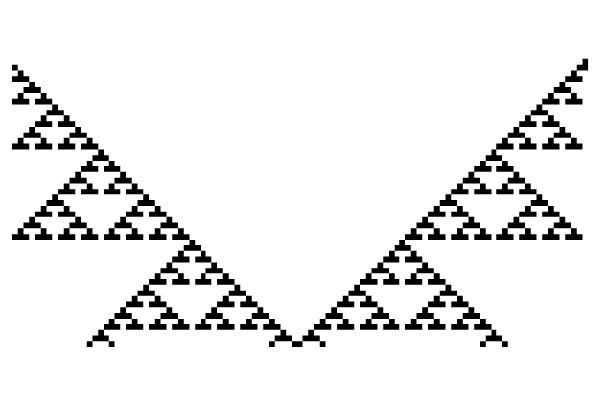

In [35]:
p, _ = run(rules = rule22, gridsize=101, nsteps = 50)
p